In [1]:
%load_ext autoreload
%autoreload 2

# Exracting PPIs

In [5]:
from ppiref.extraction import PPIExtractor
from ppiref.definitions import PPIREF_TEST_DATA_DIR

# Initialize PPI extractor based on 10A contacts between heavy atoms (as in PPIRef)
# Additionally, caluclate buried surface area (BSA) of PPIs (slow)
ppi_dir = PPIREF_TEST_DATA_DIR / 'ppi_dir'
extractor = PPIExtractor(out_dir=ppi_dir, kind='heavy', radius=10., bsa=True)

# Extract all contact-based dimer PPIs from a PDB file
pdb_file = PPIREF_TEST_DATA_DIR / '1bui.pdb'
extractor.extract(pdb_file)

# Extract a contact-based PPI between two specified chains (dimer)
extractor.extract(pdb_file, partners=['A', 'C'])

# Extract a contact-based PPI between three specified chains (trimer)
extractor.extract(pdb_file, partners=['A', 'B', 'C'])

# Extract a complete complex by setting high expansion radius aroung interface
ppi_complexes_dir = PPIREF_TEST_DATA_DIR / 'ppi_dir_dimers'
extractor = PPIExtractor( out_dir=ppi_complexes_dir, kind='heavy', radius=6., bsa=False, expansion_radius=1_000_000)
extractor.extract(pdb_file, partners=['A', 'C'])


# Analysing PPIs

2024-01-22 22:57:17.342 Python[16836:238097] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


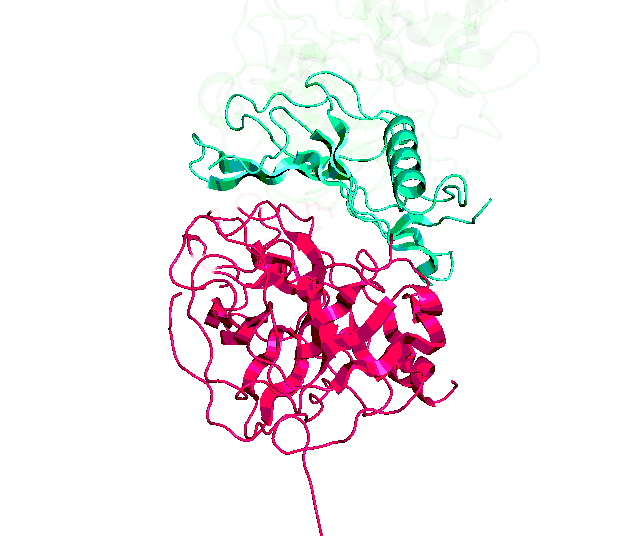

In [4]:
from ppiref.visualization import PyMOL

pymol = PyMOL()

# Visualize extracted PPIs in PyMOL session + static image
ppi_file = ppi_complexes_dir / 'bu/1bui_A_C.pdb'  # complex
pymol.display_ppi(ppi_file, sticks=False, letters=False, color_by_residues=False)

2024-01-22 22:36:41.809 Python[16405:227938] WARNING: Secure coding is not enabled for restorable state! Enable secure coding by implementing NSApplicationDelegate.applicationSupportsSecureRestorableState: and returning YES.


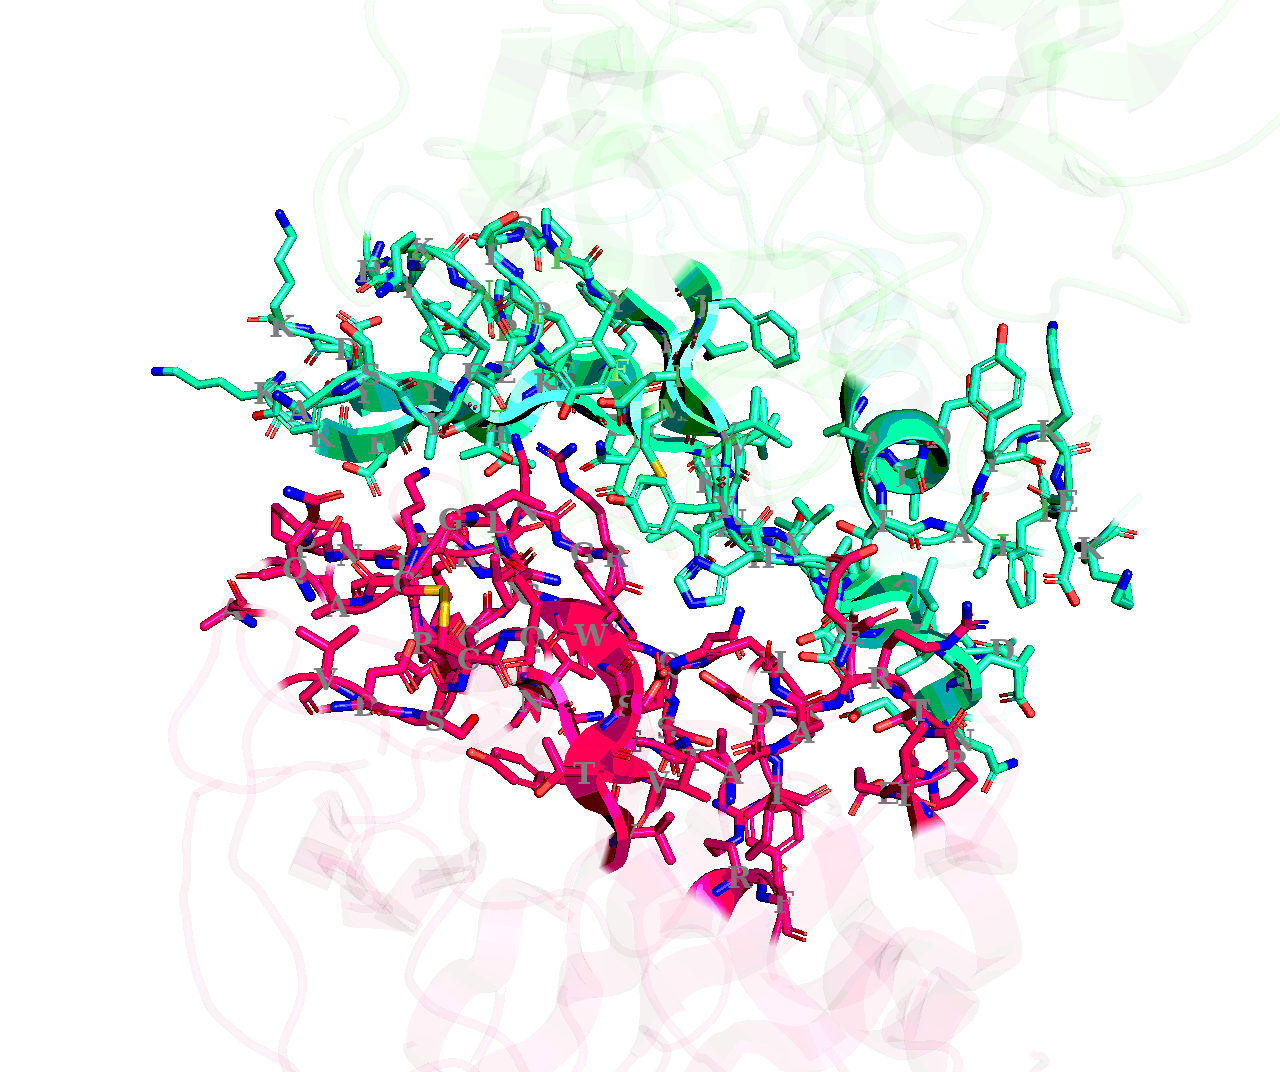

In [4]:
ppi_file = ppi_dir / 'bu/1bui_A_C.pdb'  # interface
pymol.display_ppi(ppi_file, sticks=True, letters=True, color_by_residues=False)

In [5]:
from ppiref.utils.ppi import PPI

# Get properties of a PPI
ppi = PPI(ppi_file)
ppi.stats

{'KIND': 'heavy',
 'EXTRACTION RADIUS': 6.0,
 'EXPANSION RADIUS': 1000000.0,
 'RESOLUTION': 2.65,
 'STRUCTURE METHOD': 'x-ray diffraction'}

# Comparing PPIs

In [8]:
extractor = PPIExtractor(out_dir=ppi_dir, kind='heavy', radius=6., bsa=False)
extractor.extract(PPIREF_TEST_DATA_DIR / '1p7z.pdb', partners=['A', 'C'])
extractor.extract(PPIREF_TEST_DATA_DIR / '3p9r.pdb', partners=['B', 'D'])

In [9]:
from ppiref.comparison import IAlign, USalign, IDist

# Use different methods to compare two near-duplicate PPIs from
# Figure 1 in our paper (https://arxiv.org/pdf/2310.18515.pdf)
ppis = [ppi_dir / 'p7/1p7z_A_C.pdb', ppi_dir / 'p9/3p9r_B_D.pdb']

ialign = IAlign()
ialign.compare(*ppis)

# On Linux:
# {'PPI0': '1p7z_A_C', 'PPI1': '3p9r_B_D', 'IS-score': 0.95822, 'P-value': 8.22e-67, 'Z-score': 152.167, 'Number of aligned residues': 249, 'Number of aligned contacts': 347, 'RMSD': 0.37, 'Seq identity': 0.992}

perl /Users/anton/dev/PPIRef/external/ialign/bin/ialign.pl -a 2 -w iAlign_tmp_out_1p7z_A_C_3p9r_B_D -c1 AC -c2 BD /Users/anton/dev/PPIRef/tests/data/ppi_dir/p7/1p7z_A_C.pdb /Users/anton/dev/PPIRef/tests/data/ppi_dir/p9/3p9r_B_D.pdb > iAlign_tmp_out_1p7z_A_C_3p9r_B_D/1p7z_A_C_3p9r_B_D.out


{'PPI0': '1p7z_A_C', 'PPI1': '3p9r_B_D'}

In [10]:
usalign = USalign()
usalign.compare(*ppis)

# On Linux:
# {'PPI0': '1p7z_A_C', 'PPI1': '3p9r_B_D', 'TM1': 0.992, 'TM2': 0.9965, 'RMSD': 0.3, 'ID1': 0.991, 'ID2': 0.996, 'IDali': 0.998, 'L1': 448, 'L2': 446, 'Lali': 445}

/bin/sh: /Users/anton/dev/PPIRef/external/USalign/USalign: No such file or directory


CalledProcessError: Command '/Users/anton/dev/PPIRef/external/USalign/USalign /Users/anton/dev/PPIRef/tests/data/1p7z_A_C.pdb /Users/anton/dev/PPIRef/tests/data/3p9r_B_D.pdb -outfmt 2 -mm 1 -ter 1 ' returned non-zero exit status 127.

In [8]:
ppis

[PosixPath('/Users/anton/dev/PPIRef/tests/data/ppi_dir/p7/1p7z_A_C.pdb'),
 PosixPath('/Users/anton/dev/PPIRef/tests/data/ppi_dir/p9/3p9r_B_D.pdb')]

In [10]:
idist = IDist()
idist.compare(*ppis)

/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")
/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:164: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")


[01/23/24 12:50:01] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=599343;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=933175;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py#187\187]8;;\

                    DEBUG    Detected 289 total nodes                                                 ]8;id=905971;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=830052;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py#431\431]8;;\

                    INFO     Found: 83232 KNN edges                                                ]8;id=988942;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=854400;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py#1131\1131]8;;\

[01/23/24 12:50:02] INFO     Found: 83232 KNN edges                                                ]8;id=960948;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=324007;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py#1131\1131]8;;\

/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")
/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:164: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")


[01/23/24 12:50:04] DEBUG    Deprotonating protein. This removes H atoms from the pdb_df dataframe    ]8;id=28860;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=521780;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py#187\187]8;;\

                    DEBUG    Detected 289 total nodes                                                 ]8;id=893426;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py\graphs.py]8;;\:]8;id=86746;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py#431\431]8;;\

                    INFO     Found: 83232 KNN edges                                                ]8;id=426271;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=296188;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py#1131\1131]8;;\

[01/23/24 12:50:06] INFO     Found: 83232 KNN edges                                                ]8;id=969599;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py\distance.py]8;;\:]8;id=48503;file:///Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/edges/distance.py#1131\1131]8;;\

{'PPI0': '1p7z_A_C.pdb',
 'PPI1': '3p9r_B_D.pdb',
 'L2': 0.0034661771664121184,
 'L1': 0.0069521885386008495,
 'Cosine Similarity': 0.9996311459445464}

In [11]:
idist.embed(ppis[0])
idist.embed(ppis[1])
idist.embeddings

{'1p7z_A_C': array([0.01731814, 0.00347079, 0.03816472, 0.04164083, 0.02777858,
        0.03990269, 0.02775753, 0.03471655, 0.01386247, 0.03121286,
        0.00694047, 0.03820259, 0.04857357, 0.0173353 , 0.03992103,
        0.02428673, 0.02429712, 0.01386962, 0.00347335, 0.00866032]),
 '3p9r_B_D': array([0.01904621, 0.00347081, 0.03816642, 0.04163909, 0.02777779,
        0.04163979, 0.02775733, 0.03471782, 0.01386243, 0.03121038,
        0.00694084, 0.03820353, 0.04857332, 0.01733598, 0.03818163,
        0.02428163, 0.02430092, 0.01386946, 0.00347302, 0.00693259])}

In [13]:
idist.deduplicate_embeddings()
idist.embeddings

Processing adjacency chunks: 100%|██████████| 1/1 [00:00<00:00, 348.34it/s]


{'3p9r_B_D': array([0.01904621, 0.00347081, 0.03816642, 0.04163909, 0.02777779,
        0.04163979, 0.02775733, 0.03471782, 0.01386243, 0.03121038,
        0.00694084, 0.03820353, 0.04857332, 0.01733598, 0.03818163,
        0.02428163, 0.02430092, 0.01386946, 0.00347302, 0.00693259])}

In [12]:
idist.query(idist.embeddings['1p7z_A_C'])

(array([0.        , 0.00346618]),
 array(['1p7z_A_C', '3p9r_B_D'], dtype=object))

In [13]:
print(idist.compare_all_against_all(ppis, ppis))

/Users/anton/dev/PPIRef/ppiref/comparison.py:78: UserWarning: Current implementation of parallelization uses `executor.map`. Therefore tqdm progress bar only shows 0\% and 100\%.
  warnings.warn(
Embedding PPIs (8 processes):   0%|          | 0/2 [00:00<?, ?it/s]

[01/22/24 22:58:01] WARNING  To use the Graphein submodule      embeddings.py:33
                             graphein.protein.features.sequence                 
                             .embeddings, you need to install:                  
                             torch                                              
                             To do so, use the following                        
                             command: conda install -c pytorch                  
                             torch                                              
                    WARNING  To use the Graphein submodule      embeddings.py:44
                             graphein.protein.features.sequence                 
                             .embeddings, you need to install:                  
                             biovec                                             
                             biovec cannot be installed via                     
                            

/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")
/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:164: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")


[01/22/24 22:58:02] INFO     Found: 83232 KNN edges             distance.py:1131


/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:161: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")
/Users/anton/miniconda3/envs/ppiref_test/lib/python3.9/site-packages/graphein/protein/graphs.py:164: FutureWarning: The default value of regex will change from True to False in a future version.
  df["node_id"] = df["node_id"].str.replace(":$", "")


[01/22/24 22:58:04] DEBUG    Deprotonating protein. This removes H graphs.py:187
                             atoms from the pdb_df dataframe                    
                    DEBUG    Detected 289 total nodes              graphs.py:431
                    INFO     Found: 83232 KNN edges             distance.py:1131
[01/22/24 22:58:05] INFO     Found: 83232 KNN edges             distance.py:1131


Embedding PPIs (8 processes): 100%|██████████| 2/2 [00:07<00:00,  3.98s/it]

           PPI0          PPI1        L2        L1  Cosine Similarity
0  1p7z_A_C.pdb  1p7z_A_C.pdb  0.000000  0.000000           1.000000
1  1p7z_A_C.pdb  3p9r_B_D.pdb  0.003466  0.006952           0.999631
2  3p9r_B_D.pdb  1p7z_A_C.pdb  0.003466  0.006952           0.999631
3  3p9r_B_D.pdb  3p9r_B_D.pdb  0.000000  0.000000           1.000000


# Splitting PPIs

In [14]:
from ppiref.split import read_split

split = read_split('dips_equidock', full_paths=False)
split['train'][:3]

['1v6j_A_D', '2v6a_L_A', '2v6a_B_O']

In [15]:
split = read_split('skempi2_iclr24_split', full_paths=False)
split['test'][:3]

['1B3S_A_D', '1B2U_A_D', '1BRS_A_D']

In [16]:
from ppiref.split import write_split

split = {'train': ['1p7z_A_C'], 'test': ['3p9r_B_D', '1p7z_A_C']}
write_split('demo_split', source=PPIREF_TEST_DATA_DIR / 'ppi_dir', folds=split)

/Users/anton/dev/PPIRef/ppiref/split.py:49: UserWarning: Folds train and test are not disjoint.
  warnings.warn(f'Folds {fold_a} and {fold_b} are not disjoint.')
/Users/anton/dev/PPIRef/ppiref/split.py:55: UserWarning: Split is not complete: 2 of 5 PPIs contained.
  warnings.warn(


In [17]:
split = read_split('ppiref_filtered_clustered_04', full_paths=False)
split['whole'][:3]

['4q2p_A_B', '2q2g_A_B', '6q2a_H_K']